<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch5-MonteCarloMethods/Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import scipy.io as sio
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Approach with State Value Function
1. We assume MonteCarlo approach with exploring starts to simulate many trials of episodes. This way we can guarantee that all states are visited as long as the probability of initial condition for all states is non-zero. The probabilities of drawing cards is described below.

Card | Count | Probability | Score
--- | --- | --- | ---
Ace | 1 | $\frac{4}{52}$ | 1/11
2-9 | 8 | $\frac{4}{52}$ | 2-9
10,J,Q,K|4|$\frac{4}{52}$ | 10

Total Probability = $\frac{4}{52} + 8\times\frac{4}{52} + 4\times\frac{4}{52} = 1$

2. The reward is applied at the end of each episode with discount rate, $\gamma = 1$.

Outcome | Reward
--- | --- 
Player wins | 1 
Draw | 0 
Player loses|-1

3. The state values are the concatenated values of the following:

> *   Presence of atleast one useable Ace. This state has cardinality = 2 (presence/absence of useable ace). The player could be drawing aces at any of his "hits", so the checkUsableAce function below checks for his current hand, latest draw and determines if any aces in his hand can be made useable. If this can be made useable, then the state value is set to 0, else it assumes the value 1.
> *   Current sum for the player (12-21). Sum of 22 leads to loss which is reflected in the reward, so this value is ignored. Sum less than 12 is a trivial case where the player has to hit to have some probability of winning.
> *   Dealer's open card value. This state assumes values (A-10) where the face cards are clubbed into the category for the card valued 10 as shown in the probability table above.



4. The make_policy function below makes the policy based on the condition for sticks for each player. For the first example, the dealer sticks when his total is 17 or more and the player sticks if his total is 20 or 21. The fuction initializes the policy as follows:

$$\begin{align*} \pi(\text{stick}) =& \Bigg\{ \begin{matrix} 1 & \text{if total} \ge \text{stick value} \\ 0 & \text{otherwise} \end{matrix} \\
\pi(\text{hit}) =& 1-\pi(\text{stick})\end{align*}$$

5. Both first-visit and every-visit MC methods for his problem are identical since all cards have are non-zero i.e., the transition probability from a state to itself is zero for all actions in all states.

$$ P(s_{k+1}=s_k|s_k,a_k) = 0$$


### Code

In [8]:
cards = np.array(range(1,11))
prob_cards = 4/52*np.ones(cards.shape)
prob_cards[-1] = 1-np.sum(prob_cards[:-1])
draw_distribution = stats.rv_discrete(name='custm', values=(cards, prob_cards))

max_score = 22
def make_policy(stick):
  pi = np.zeros((2,10,10))
  for i in range(12,max_score):
    if i < stick:
      pi[:,i-12,:] = 0
    else:
      pi[:,i-12,:] = 1
  return pi

def card_draw(distribution,num=1):
  return list(distribution.rvs(size=num))

def checkUsableAce(hand,current):
  total = np.sum(hand)
  new_total = total + current
  if len(hand) == 0 and current == 1:
    ### usable ace
    return [11]
  elif current == 1:
    if new_total+10 <= max_score-1:
      ### usable ace
      return hand + [11]
  if new_total >= max_score and 11 in hand[1:]:
    idx = hand[1:].index(11)
    hand[idx+1] = 1
  return hand + [current]

def testUsableAce():
  test_cases = [[1,4],[4,1],[5,4],[10,1],[1],[11,1],[5,4,5,1],[11,2,2,2,2,2,2,2]]
  for hand in test_cases:
    print("Test case: ")
    print('Current = ', hand[:-1])
    print('New = ', hand[-1])
    print(checkUsableAce(hand[:-1],hand[-1]))
    print()

def computeReward(player_total,dealer_total):
  reward = 0
  if player_total == max_score:
    reward = -1
  elif (player_total == max_score-1 and dealer_total != max_score-1):
    reward = 1
  elif player_total < max_score-1:
    if dealer_total == max_score:
      reward = 1
    elif dealer_total == max_score-1:
      reward = -1
    elif player_total > dealer_total:
      reward = 1
    elif player_total < dealer_total:
      reward = -1
  return reward

def simulate_turn(draw_distribution,current,dealer_card,pi):
  if dealer_card == 11:
    dealer_card = 1
  final_sum = min(max_score,np.sum(current))
  hand = current
  row = 0
  if 11 in hand:
    row = 1
  hit_prob = np.random.uniform(0,1,1)[0]
  hit_cond = True
  if final_sum >= 12 and final_sum < max_score:
    hit_cond = hit_prob > pi[row,final_sum-12,dealer_card-1]
  # print(row,final_sum-12,dealer_card-1)
  # print(hit_cond,hit_prob,pi[row,final_sum-12,dealer_card-1])
  while final_sum < max_score and hit_cond:
    hand = checkUsableAce(hand,card_draw(draw_distribution,1)[0])
    final_sum = min(max_score,np.sum(hand))
    if 11 in hand:
      row = 1
    hit_prob = np.random.uniform(0,1,1)[0]
    hit_cond = True
    if final_sum >= 12 and final_sum < max_score:
      # print(row,final_sum-12,dealer_card-1)
      # print(hit_cond,hit_prob,pi[row,final_sum-12,dealer_card-1])
      hit_cond = hit_prob > pi[row,final_sum-12,dealer_card-1]
  return final_sum,hand

def simulate_game(draw_distribution,pi_dealer,pi_player,init_player=-1):
  player_cards = []
  for i in range(2):
    if init_player != -1 and i == 0:
      player_cards.append(init_player)
      continue
    player_cards = checkUsableAce(player_cards,card_draw(draw_distribution,1)[0])
  dealer_card = checkUsableAce([],card_draw(draw_distribution,1)[0])

  player_total,player_hand = simulate_turn(draw_distribution,player_cards,dealer_card[0],pi_player)
  dealer_total,dealer_hand = simulate_turn(draw_distribution,dealer_card,player_hand[0],pi_dealer)
  
  reward = computeReward(player_total,dealer_total)
  
  # print("Player:",player_cards,player_total)
  # print(player_hand)
  # print("Dealer:",dealer_card,dealer_total)
  # print(dealer_hand)
  # print("Reward:",reward)
  
  player_cumTotal = np.cumsum(player_hand)
  idx1 = np.where(player_cumTotal >= 12)[0]
  idx = idx1[np.where(player_cumTotal[idx1] < 22)[0]]

  row = 0
  if 11 in player_hand:
    row = 1

  jj = dealer_hand[0]-1
  if dealer_hand[0] == 11:
    jj = 0

  for i in idx:
    ii = player_cumTotal[i]-12
    val_func[row,ii,jj] = val_func[row,ii,jj] + reward
    val_count[row,ii,jj] = val_count[row,ii,jj] + 1.0

# testUsableAce()

In [9]:
pi_dealer = make_policy(17)
pi_player = make_policy(20)

load_result = False

In [20]:
if load_result:
  mat_dict = sio.loadmat("/content/gdrive/My Drive/Colab Notebooks/Blackjack.mat")
  val_func = mat_dict['val_func']
  val_count = mat_dict['val_count']
  num_trials = mat_dict['num_trials']
else:
  num_trials = 100000
  val_func = np.zeros((2,10,10))
  val_count = np.zeros((2,10,10))
  for i in range(num_trials):
    simulate_game(draw_distribution,pi_dealer,pi_player,-1)
    if i%5 == 0:
      simulate_game(draw_distribution,pi_dealer,pi_player,11)
  sio.savemat("/content/gdrive/My Drive/Colab Notebooks/Blackjack.mat",{'val_func':val_func,'val_count':val_count,'num_trials':num_trials})

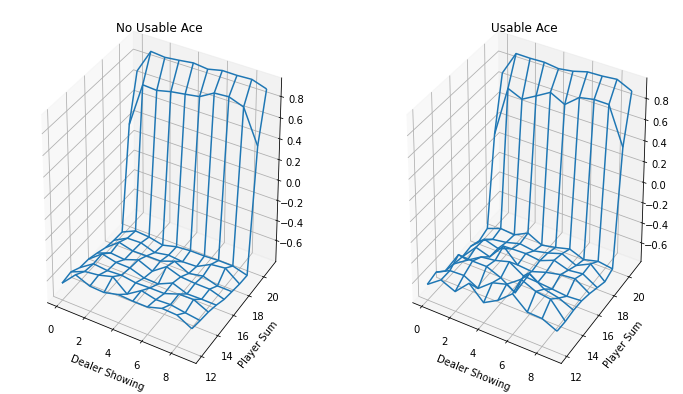

In [21]:
fig = plt.figure(figsize=(12,7))
y = list(range(12,22))
x = list(range(10))
X,Y = np.meshgrid(x,y)
title = ['No Usable Ace', 'Usable Ace']
for i in range(2):
  ax = fig.add_subplot(1, 2, i+1, projection='3d')
  ax.set_title(title[i])
  ax.plot_wireframe(X, Y, val_func[i,:,:]/val_count[i,:,:],rstride=1,cstride=1)
  ax.set_xlabel('Dealer Showing')
  ax.set_ylabel('Player Sum')
  # ax.view_init(elev=50., azim=-60)

## Generalized Value Iteration using MonteCarlo ES

In [7]:
pi_player_action = [make_policy(20),make_policy(20)]

In [154]:
action_val_func = np.zeros((2,10,10,2))
action_val_count = np.zeros((2,10,10,2))

def simulate_turn_action(draw_distribution,current,dealer_card,pi):
  if dealer_card == 11:
    dealer_card = 1
  final_sum = min(max_score,np.sum(current))
  hand = current
  row = 1
  if 11 in hand:
    row = 0
  hit_prob = np.random.uniform(0,1,1)[0]
  hit_cond = True
  if final_sum >= 12:
    hit_cond = hit_prob <= pi[row,final_sum-12,dealer_card-1]

  while final_sum < max_score and hit_cond:
    hand = checkUsableAce(hand,card_draw(draw_distribution,1)[0])
    final_sum = min(max_score,np.sum(hand))
    if 11 in hand:
      row = 0
    hit_prob = np.random.uniform(0,1,1)[0]
    hit_cond = True
    if final_sum >= 12 and final_sum < max_score:
      # print(row,final_sum,dealer_card-1)
      hit_cond = hit_prob <= pi[row,final_sum-12,dealer_card-1]
  return final_sum,hand

def simulate_game_wAction(draw_distribution,pi_dealer,pi_player):
  player_cards = []
  for i in range(2):
    player_cards = checkUsableAce(player_cards,card_draw(draw_distribution,1)[0])
  dealer_card = checkUsableAce([],card_draw(draw_distribution,1)[0])

  player_total,player_hand = simulate_turn_action(draw_distribution,player_cards,dealer_card[0],pi_player)
  dealer_total,dealer_hand = simulate_turn(draw_distribution,dealer_card,pi_dealer)
  
  reward = computeReward(player_total,dealer_total)
   
  player_cumTotal = np.cumsum(player_hand)
  idx1 = np.where(player_cumTotal >= 12)[0]
  idx = idx1[np.where(player_cumTotal[idx1] < 22)[0]]

  row = 1
  if player_hand[0] in [1,11]:
    row = 0

  jj = dealer_hand[0]-1
  if dealer_hand[0] == 11:
    jj = 0

  for i in idx:
    ii = player_cumTotal[i]-12
    kk = 0 #hit
    if i == len(player_cumTotal)-1:
      kk = 1 #stick
    action_val_func[row,ii,jj,kk]  = action_val_func[row,ii,jj,kk] + reward
    action_val_count[row,ii,jj,kk] = action_val_count[row,ii,jj,kk] + 1.0
  return row

def init_dict(keys):
  res = dict()
  for k in keys:
    res[k] = 0.0
  return res

def improve_policy(pi_current,usableAce=False):
  item = 1
  pi_new = np.zeros(pi_current.shape)

  if usableAce:
    item = 0
    pi_new[1,:,:] = np.copy(pi_current[1,:,:])
  else:
    pi_new[0,:,:] = np.copy(pi_current[0,:,:])

  act = action_val_func/np.maximum(1,action_val_count)
  for ii in range(act.shape[1]):
      for jj in range(act.shape[2]):
        prob = 0.5
        if act[item,ii,jj,0] > act[item,ii,jj,1]:
          prob = 1
        else:
          prob = 0
        pi_new[item,ii,jj] = prob         
  return pi_new


In [157]:
load_result = False
if load_result:
  mat_dict = sio.loadmat("/content/gdrive/My Drive/Colab Notebooks/Blackjack.mat")
  action_val_func = mat_dict['action_val_func']
  action_val_count = mat_dict['action_val_count']
else:
  num_trials = 100000
  pi_player_current = make_action_policy(20)
  for i in range(num_trials):
    row = simulate_game_wAction(draw_distribution,pi_dealer,pi_player_current)
    usableAce = False
    if row == 0:
      usableAce = True
    # print("Starting policy Improvement!")
    pi_player_new = improve_policy(pi_player_current,usableAce)
    for i in range(len(pi_player_action)):
      pi_player_current[i] = pi_player_new[i].copy()
  # sio.savemat("/content/gdrive/My Drive/Colab Notebooks/Blackjack.mat",{'val_func':val_func,'val_count':val_count,'num_trials':num_trials,'action_val_func':action_val_func,'action_val_count':action_val_count,})

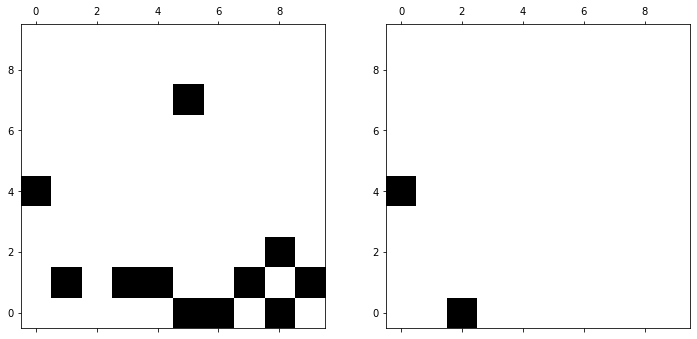

In [158]:
fig = plt.figure(figsize=(12,7))
for i in range(2):
  ax = fig.add_subplot(1, 2, i+1)
  ax.matshow(pi_player_current[i,:,:],cmap='binary')
  ax.invert_yaxis()
# print(pi_player_current[0,:,:])

In [159]:
print(pi_player_current[0,:,:])

[[0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
